<a href="https://colab.research.google.com/github/M4mbo/Supervised_Approaches_to_CIFAR10/blob/main/Supervised_Approaches_to_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, we will evaluate the performance of different supervised approaches to the CIFAR10 dataset using pytorch

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torchvision import models,transforms
from torchvision.utils import make_grid
from torchvision.datasets import CIFAR10
from torch.utils.data.sampler import SubsetRandomSampler
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

We will be using [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) datasets which is sub-dataset of CIFAR-100 Dataset. The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images. <br>

Following are the classes in the dataset along with some random samples.

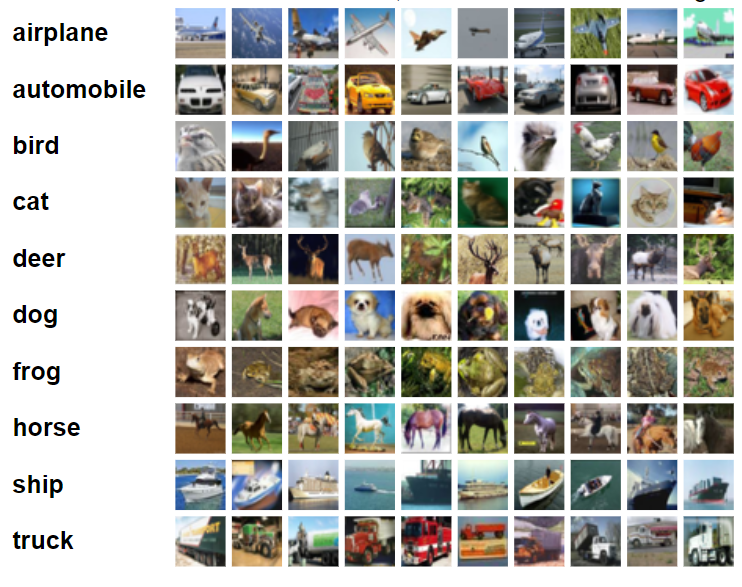

We will use pytorch datasets to fetch the CIFAR-10 dataset as it provides a handy way to get and use the dataset.


In [2]:
def cifar10(batch_sz, valid_size=0.2, shuffle=True, random_seed=2000):
  transform_train = transforms.Compose([
      transforms.ToTensor(),
  ])
  transform_valid = transforms.ToTensor()
  transform_test = transforms.ToTensor()

  train_dataset = CIFAR10(root='./datasets', train=True, download=True, transform=transform_train)
  valid_dataset = CIFAR10(root='./datasets', train=True, download=True, transform=transform_valid)

  num_train = len(train_dataset)
  indices = list(range(num_train))
  split = int(np.floor(valid_size * num_train))
  if shuffle:
    np.random.seed(random_seed)
    np.random.shuffle(indices)
  train_idx, valid_idx = indices[split:], indices[:split]

  train_sampler = SubsetRandomSampler(train_idx)
  valid_sampler = SubsetRandomSampler(valid_idx)
  train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_sz, sampler=train_sampler, pin_memory=True)
  valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_sz, sampler=valid_sampler, pin_memory=True)

  test_dataset = CIFAR10(root='./datasets', train=False, download=True, transform=transform_test)
  test_loader = DataLoader(test_dataset, batch_size=batch_sz)

  return train_loader, valid_loader, test_loader


In [3]:
batch_sz=64 # this is batch size i.e. the number of rows in a batch of data

train_loader, valid_loader, test_loader = cifar10(batch_sz)

100%|██████████| 170498071/170498071 [00:05<00:00, 29070972.22it/s]


Extracting ./datasets/cifar-10-python.tar.gz to ./datasets
Files already downloaded and verified
Files already downloaded and verified


In [4]:
def label_str(x):
  labels = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
  return(labels[x])

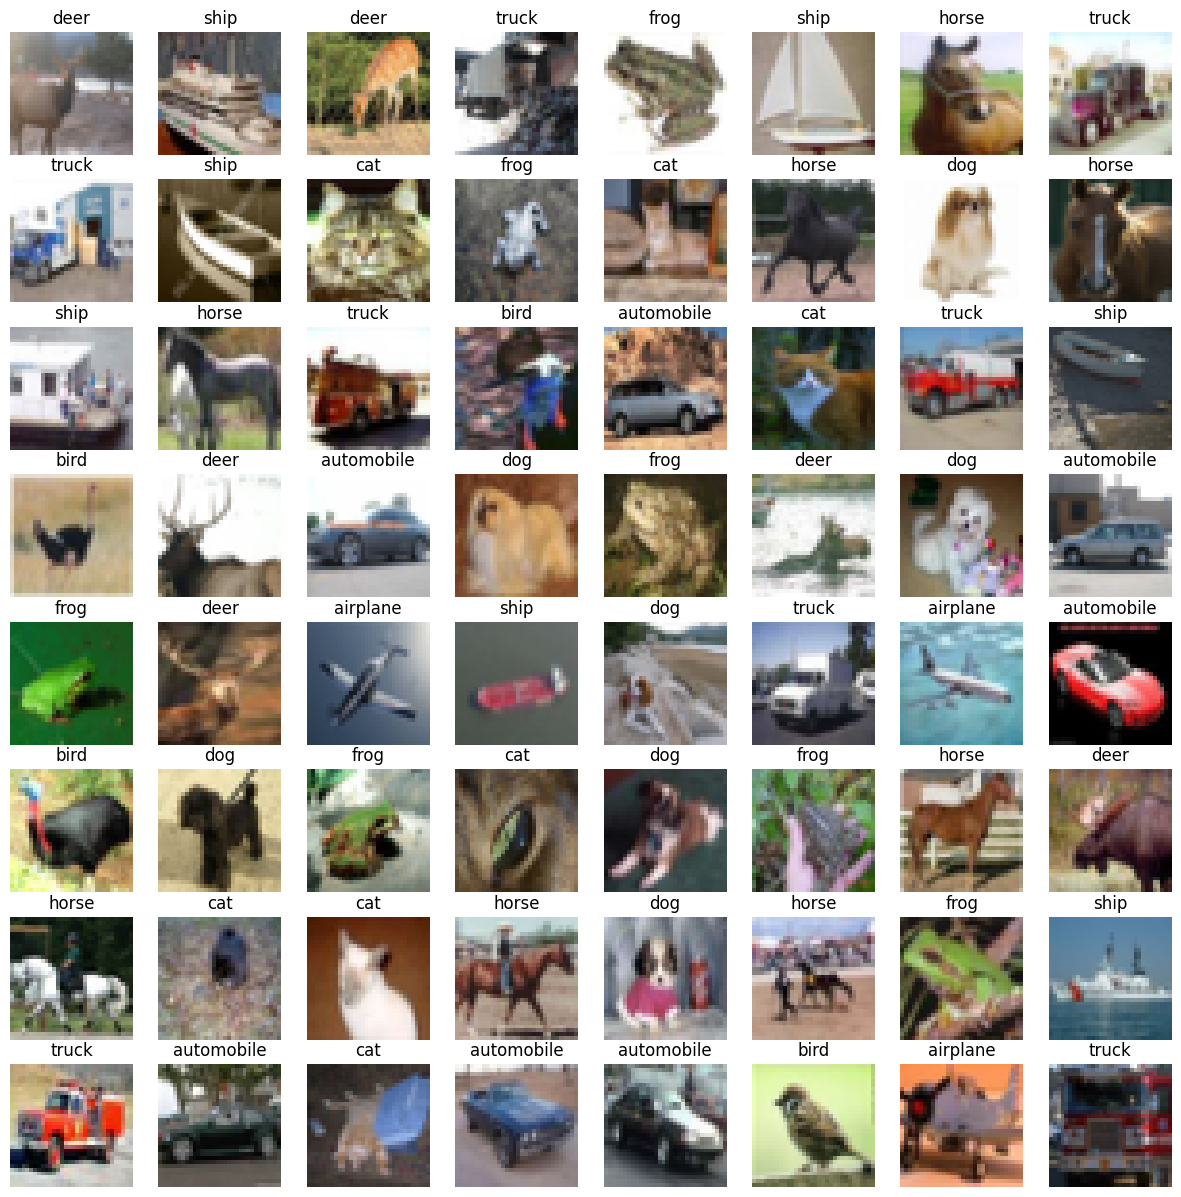

In [5]:
batch = next(iter(train_loader))
images = batch[0]
labels = batch[1]
plt.figure(figsize=(15,15))
for i in range(64):
  plt.subplot(8,8,i+1)
  img = np.transpose(images[i].numpy(), (1, 2, 0))  # Transpose the image dimensions
  plt.imshow(img)
  plt.title(label_str(labels[i].item()))
  plt.axis("off")

To begin with, let's start with a simple deep NN of 5 layers with no activation function on the last layer. We will be using ReLu to introduce non linearazation.

In [6]:
class MyNN(nn.Module):
  def __init__(self, ni, nh1, nh2, nh3, nh4, no):
    super().__init__()
    self.layer1 = nn.Linear(ni,nh1)
    self.layer2 = nn.Linear(nh1, nh2)
    self.layer3 = nn.Linear(nh2, nh3)
    self.layer4 = nn.Linear(nh3, nh4)
    self.layer5 = nn.Linear(nh4, no)

  def forward(self, x):
    x = x.view(-1, ni)

    x = self.layer1(x)
    x = torch.relu(x)

    x = self.layer2(x)
    x = torch.relu(x)

    x = self.layer3(x)
    x = torch.relu(x)

    x = self.layer4(x)
    x = torch.relu(x)

    x = self.layer5(x)

    return (x)


This will be our main training loop for n epochs. The learning rate is adjusted after every epoch to reach the minima faster (learn faster)

In [7]:
def train(net, num_epochs, lr, momentum):

  # Specify a folder under run for tensorboard data for the training

  writer = SummaryWriter("runs/lr_1")
  device = torch.device('cuda:0')

  net = net.to(device)

  optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum)

  lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9, verbose=True)

  train_losses = []
  val_losses = []

  for i in range(num_epochs):

      loss_total = 0
      loss_val = 0
      acc_train = 0
      total_train = 0

      for ii, batch in enumerate(train_loader):

          data = batch[0]
          label = batch[1]
          optimizer.zero_grad()
          data, label = data.to(device), label.to(device)
          logits = net(data)
          if isinstance(logits, tuple):  # If the model returns a tuple
            logits = logits[0]
          else:  # If the model returns a single tensor
            logits = logits
          loss = F.cross_entropy(logits, label)
          loss_total += loss.item()
          loss.backward()
          optimizer.step()
          out = torch.argmax(logits, dim=1)
          acc_train += torch.sum(out == label)
          total_train += logits.shape[0]

      acc_val = 0
      total_val = 0

      with torch.no_grad():

          for jj, batch in enumerate(valid_loader):
              data = batch[0]
              label = batch[1]
              data, label = data.to(device), label.to(device)
              logits = net(data)
              if isinstance(logits, tuple):  # If the model returns a tuple
                logits = logits[0]
              else:  # If the model returns a single tensor
                logits = logits
              loss = F.cross_entropy(logits, label)
              loss_val += loss.item()
              out = torch.argmax(logits, dim=1)
              acc_val += torch.sum(out == label)
              total_val += logits.shape[0]

      train_loss_avg = loss_total / ii
      val_loss_avg = loss_val / jj
      train_acc_avg = acc_train.item() / total_train
      val_acc_avg = acc_val.item() / total_val
      train_losses.append(train_loss_avg)
      val_losses.append(val_loss_avg)
      lr_scheduler.step()

      if i % 2 == 0:
        print(f"Epoch {i}: Training Loss: {train_loss_avg}, Validation Loss: {val_loss_avg}")
        print(f"Epoch {i}: Training Accuracy: {train_acc_avg}, Validation Accuracy: {val_acc_avg}")


      writer.add_scalar('Loss/train', train_loss_avg, i)
      writer.add_scalar('Loss/test', val_loss_avg, i)
      writer.add_scalar('Accuracy/train', train_acc_avg, i)
      writer.add_scalar('Accuracy/test', val_acc_avg, i)

  print(f"Final Training Loss: {train_loss_avg}, Final Validation Loss: {val_loss_avg}")
  print(f"Final Training Accuracy: {train_acc_avg}, Final Validation Accuracy: {val_acc_avg}")

  # Plot the data
  plt.plot(train_losses, label='Training Set')
  plt.plot(val_losses, label='Validation Set')

  # Add legend
  plt.legend()

  # Add title and labels
  plt.title('Loss vs Epochs')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')

  # Display the graph
  plt.show()

  return train_losses, val_losses


The confusion function will display a confusion matrix using heat maps from the seaborn library. This will give us an idea on how the network is mismatching labels.

In [8]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

def confusion(dataloader, net):

  device = torch.device('cuda:0')
  net = net.to(device)

  predictions = []
  true = []
  with torch.no_grad():
    for batch in dataloader:
        data = batch[0]
        label = batch[1]
        data, label = data.to(device), label.to(device)
        logits = net(data)
        if isinstance(logits, tuple):  # If the model returns a tuple
          logits = logits[0]
        else:  # If the model returns a single tensor
          logits = logits
        predictions.extend(torch.argmax(logits, dim=1).cpu().detach().numpy())
        true.extend(label.cpu().detach().numpy())

  # Compute the confusion matrix for training data
  ax = plt.subplot()
  cm = confusion_matrix(true, predictions)
  sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)

  # Set labels, title, and tick parameters
  ax.set_xlabel('Predicted Labels')
  ax.set_ylabel('True Labels')
  ax.set_title('Confusion Matrix')
  ax.xaxis.set_ticklabels([label_str(0), label_str(1), label_str(2), label_str(3), label_str(4), label_str(5), label_str(6), label_str(7), label_str(8), label_str(9)])
  ax.yaxis.set_ticklabels([label_str(0), label_str(1), label_str(2), label_str(3), label_str(4), label_str(5), label_str(6), label_str(7), label_str(8), label_str(9)], rotation=0, ha='right')

  # Rotate the tick labels for better readability
  plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

  # Display the plot
  plt.tight_layout()
  plt.show()

In [9]:
def test(net):

  device = torch.device('cuda:0')
  net = net.to(device)
  net.eval()
  with torch.no_grad():
    total_loss = 0
    acc_test = 0
    total_test = 0
    for batch in test_loader:
      data = batch[0]
      label = batch[1]
      data, label = data.to(device), label.to(device)
      logits = net(data)
      if isinstance(logits, tuple):  # If the model returns a tuple
        logits = logits[0]
      else:  # If the model returns a single tensor
        logits = logits
      loss = F.cross_entropy(logits, label)
      total_loss += loss.item()
      out = torch.argmax(logits, dim=1)
      acc_test += torch.sum(out == label)
      total_test += logits.shape[0]

    print(f"Testing Loss: {total_loss/len(test_loader)}")
    print(f"Testing Accuracy: {acc_test/total_test}")

In [10]:
# There are 3 channels (RGB images) and each image is 32 by 32 pixels
ni = 3*32*32

# Hidden units
nh1 = 40
nh2 = 60
nh3 = 80
nh4 = 100

# Output classes, 10 for CIFAR10
no = 10

net1 = MyNN(ni, nh1, nh2, nh3, nh4, no)

Now we can call the training loop for 10 epochs

Adjusting learning rate of group 0 to 2.0000e-02.
Adjusting learning rate of group 0 to 1.8000e-02.
Epoch 0: Training Loss: 2.0669676644297748, Validation Loss: 1.9244252473880084
Epoch 0: Training Accuracy: 0.2236, Validation Accuracy: 0.3009
Adjusting learning rate of group 0 to 1.6200e-02.
Adjusting learning rate of group 0 to 1.4580e-02.
Epoch 2: Training Loss: 1.744417415979581, Validation Loss: 1.7601907497797258
Epoch 2: Training Accuracy: 0.367175, Validation Accuracy: 0.3584
Adjusting learning rate of group 0 to 1.3122e-02.
Adjusting learning rate of group 0 to 1.1810e-02.
Epoch 4: Training Loss: 1.6391295446799352, Validation Loss: 1.6356472204893062
Epoch 4: Training Accuracy: 0.406775, Validation Accuracy: 0.4124
Adjusting learning rate of group 0 to 1.0629e-02.
Adjusting learning rate of group 0 to 9.5659e-03.
Epoch 6: Training Loss: 1.5631909366601553, Validation Loss: 1.5902440418035557
Epoch 6: Training Accuracy: 0.43715, Validation Accuracy: 0.4361
Adjusting learning r

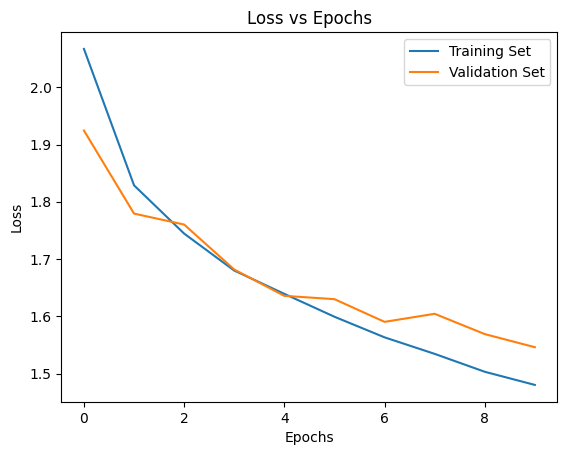

In [11]:
simpleNN_tr, simpleNN_val = train(net1, 10, 2e-2, 0.8)

As expected, the performance of a simple deep NN for images is not as high as other models, with a final accuracy of 46.8% on the training set and 44.7% on the validation set. Judging from the graph, we can state that the model is not overfitting on the training set, as the validation loss function appears to have a negative gradient until the last epoch (expect for some spikes). There are other models, like CNNs which can capture the complexity of images on a much more effective manner.

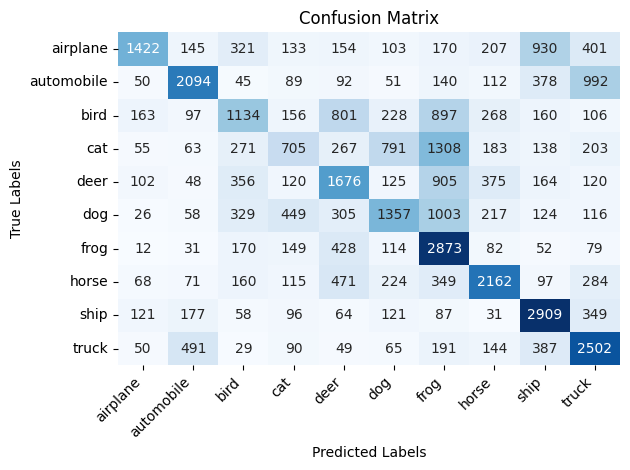

In [12]:
confusion(train_loader, net1)

Judging from the confusion matrix, we can observe that the biggest missmatch lies on cats and frogs! This results a little weird. Howver, we can observe also a big mismatch between cats and dogs. We can make some sense out of this information, as it can happen that these 2 species are the animals which look alike the most out of all the classes in the dataset. However, there are some unpredictable mismatches between labels like frogs and dogs, dogs and airplanes, trucks and automobiles, etc.

In [13]:
test(net1)

Testing Loss: 1.516066481353371
Testing Accuracy: 0.4617999792098999


We get a final testing accuracy of 45.6% after 10 epochs

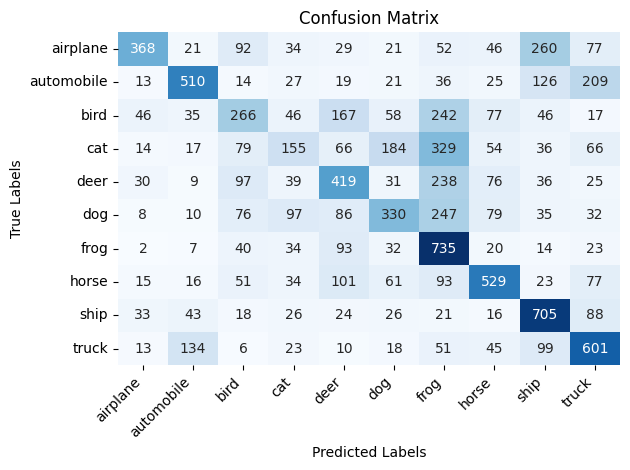

In [14]:
confusion(test_loader, net1)

Now let's build a deep CNN to compare the performance of a much more complex model. The feature extractor will be using max pooling to reduce the dimensions of the features and it will have 3 convolutional layers. The classifier on the other hand will use ReLu as the activation function and will contain 4 linear layers

In [15]:
class MyCNN(nn.Module):
  def __init__(self, in_ch, out_ch1, out_ch2, out_ch3, k_sz, nh1, nh2, nh3, no, stride):
    super().__init__()
    #(in_channels, out_channels, kernell_size, stride)
    self.conv1 = nn.Conv2d(in_ch, out_ch1, k_sz, stride)
    self.conv2 = nn.Conv2d(out_ch1, out_ch2, k_sz, stride)
    self.conv3 = nn.Conv2d(out_ch2, out_ch3, k_sz, stride)

    self.linear1 = nn.Linear(out_ch3*2*2, nh1)
    self.linear2 = nn.Linear(nh1, nh2)
    self.linear3 = nn.Linear(nh2, nh3)
    self.linear4 = nn.Linear(nh3, no)

  def forward(self, x):
    # Feature extractor
    # Torch convention --->(batch_size, channels, rows, cols)
    # x---->(bs,3, 32,32)
    x = self.conv1(x)
    x = torch.relu(x)
    # x ---->(bs, out_ch1, 30, 30)
    x1 = F.max_pool2d(x, (2,2))
    # x ---->(bs, out_ch1, 15, 15)
    x = self.conv2(x1)
    x = torch.relu(x)
    # x ---->(bs, out_ch2, 13, 13)
    x2 = F.max_pool2d(x, (2,2))
    # x ---->(bs, out_ch2, 6, 6)
    x = self.conv3(x2)
    x = torch.relu(x)
    # x ---->(bs, out_ch3, 4, 4)
    x3 = F.max_pool2d(x, (2,2))
    # x ---->(bs, out_ch3, 2, 2)

    # Classifier
    x = x3.view(-1, out_ch3*2*2)

    # x ---->(bs, out_ch3*2*2)
    x = self.linear1(x)
    x = torch.relu(x)
    x = self.linear2(x)
    x = torch.relu(x)
    x = self.linear3(x)
    x = torch.relu(x)
    x = self.linear4(x)
    #x --->(bs, no)

    return (x, x1, x2, x3)

This function will help us visualize the intermediate features of the model. We should expect edges and textures in the first layers to then see images growing in complexity for later layers

In [16]:
def visualize_intermediate_features(dataloader, net):
  device = torch.device('cuda:0')
  net = net.to(device)

  with torch.no_grad():
    batch = next(iter(dataloader))
    data = batch[0]
    label = batch[1]
    data, label = data.to(device), label.to(device)
    logits, Y1, Y2, Y3 = net(data)
    Y1 = Y1.detach().cpu().numpy()
    Y2 = Y2.detach().cpu().numpy()
    Y3 = Y3.detach().cpu().numpy()
    data = data.detach().cpu().numpy()

  plt.figure()

  # Display the original image
  plt.imshow(np.transpose(data[0], (1, 2, 0)))
  plt.title('Original Image')
  plt.axis('off')

  plt.figure(figsize=(12, 5))
  sample_number = 0

  for i in range(int(Y1.shape[1]/2)):
    plt.subplot(2, 5, i+1)
    plt.imshow(Y1[sample_number, i])  # Iterate through the channels to extract the features
    plt.title("X1." + str(i+1))
    plt.axis('off')

  plt.figure(figsize=(12, 3))
  for i in range(int(Y2.shape[1]/2)):
    plt.subplot(2, 10, i+1)
    plt.imshow(Y2[sample_number, i])  # Iterate through the channels to extract the features
    plt.title("X2." + str(i+1))
    plt.axis('off')

  plt.figure(figsize=(12, 4))
  for i in range(int(Y3.shape[1]/2)):
    plt.subplot(3, 10, i+1)
    plt.imshow(Y3[sample_number, i])  # Iterate through the channels to extract the features
    plt.title("X3." + str(i+1))
    plt.axis('off')

  plt.subplots_adjust(hspace=0.5)

  plt.show()


In [17]:
in_ch = 3
out_ch1 = 20
out_ch2 = 40
out_ch3 = 60
k_sz = 3
nh1 = 60
nh2 = 120
nh3 = 240
no = 10
stride = 1

net2 = MyCNN(in_ch, out_ch1, out_ch2, out_ch3, k_sz, nh1, nh2, nh3, no, stride)

This network will have 20, 40 and 60 channels for the feature extractor

Adjusting learning rate of group 0 to 2.0000e-02.
Adjusting learning rate of group 0 to 1.8000e-02.
Epoch 0: Training Loss: 2.2862632072124724, Validation Loss: 2.2536140359365024
Epoch 0: Training Accuracy: 0.113925, Validation Accuracy: 0.135
Adjusting learning rate of group 0 to 1.6200e-02.
Adjusting learning rate of group 0 to 1.4580e-02.
Epoch 2: Training Loss: 1.497587194809547, Validation Loss: 1.4213893772699895
Epoch 2: Training Accuracy: 0.4441, Validation Accuracy: 0.4733
Adjusting learning rate of group 0 to 1.3122e-02.
Adjusting learning rate of group 0 to 1.1810e-02.
Epoch 4: Training Loss: 1.1737252999192629, Validation Loss: 1.1829875241487453
Epoch 4: Training Accuracy: 0.580475, Validation Accuracy: 0.5769
Adjusting learning rate of group 0 to 1.0629e-02.
Adjusting learning rate of group 0 to 9.5659e-03.
Epoch 6: Training Loss: 0.9866865139741164, Validation Loss: 1.0814644010403218
Epoch 6: Training Accuracy: 0.6494, Validation Accuracy: 0.62
Adjusting learning rate 

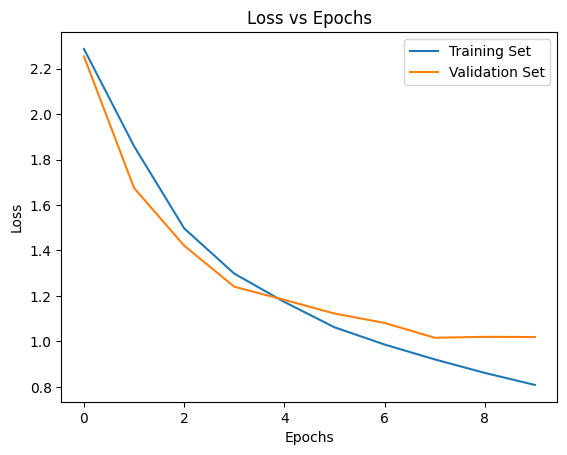

In [18]:
conv10_tr, conv10_val = train(net2, 10, 2e-2, 0.9)

We can observe already that the CNN is performing much better, with 71.3% accuracy for the training set and 64.3% accuracy for the validation set. There is no clear overfitting going on, but this might also because we are only training for 10 epochs, and the model can't overfit yet.

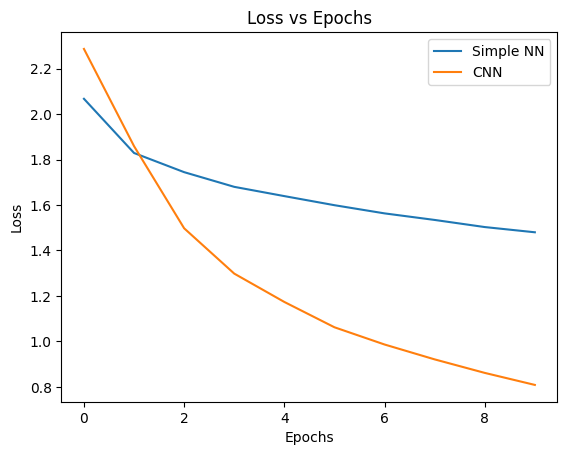

In [19]:
# Plot the data
plt.plot(simpleNN_tr, label='Simple NN')
plt.plot(conv10_tr, label='CNN')

# Add legend
plt.legend()

# Add title and labels
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Display the graph
plt.show()

This graph compares the training loss function for the simple NN and CNN. It is clear that a much more complex model like the CNN, which applies filters to the images performs much better, with a steeper gradient that becomes more notorious at around 1 epoch (from the start!).

In [20]:
in_ch = 3
out_ch1 = 20
out_ch2 = 40
out_ch3 = 60
k_sz = 3
nh1 = 60
nh2 = 120
nh3 = 240
no = 10
stride = 1

net3 = MyCNN(in_ch, out_ch1, out_ch2, out_ch3, k_sz, nh1, nh2, nh3, no, stride)

However, it is not that easy to assess the model by training it for just 10 epochs, so why not try it for double the number of epochs.

Adjusting learning rate of group 0 to 2.0000e-02.
Adjusting learning rate of group 0 to 1.8000e-02.
Epoch 0: Training Loss: 2.264877031628902, Validation Loss: 2.135426701643528
Epoch 0: Training Accuracy: 0.1267, Validation Accuracy: 0.2168
Adjusting learning rate of group 0 to 1.6200e-02.
Adjusting learning rate of group 0 to 1.4580e-02.
Epoch 2: Training Loss: 1.4955957661836574, Validation Loss: 1.3690657554528651
Epoch 2: Training Accuracy: 0.4514, Validation Accuracy: 0.5034
Adjusting learning rate of group 0 to 1.3122e-02.
Adjusting learning rate of group 0 to 1.1810e-02.
Epoch 4: Training Loss: 1.1647480479799783, Validation Loss: 1.2038529637532356
Epoch 4: Training Accuracy: 0.579775, Validation Accuracy: 0.5764
Adjusting learning rate of group 0 to 1.0629e-02.
Adjusting learning rate of group 0 to 9.5659e-03.
Epoch 6: Training Loss: 0.9905569578210512, Validation Loss: 1.056394950319559
Epoch 6: Training Accuracy: 0.6493, Validation Accuracy: 0.6332
Adjusting learning rate o

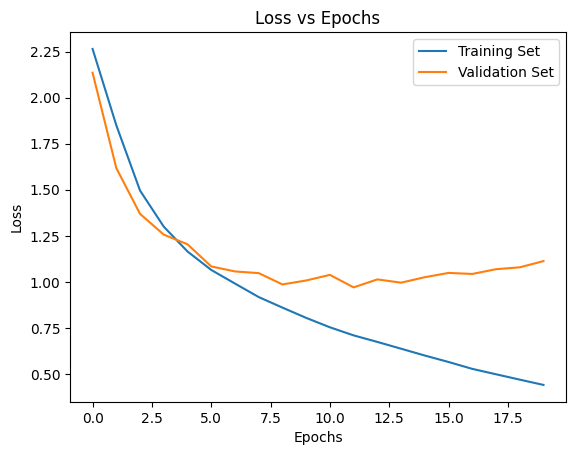

In [21]:
conv20_tr, conv20_val = train(net3, 20, 2e-2, 0.9)

This graphs shows us a better understanding of how a model like this may overfit on the training set. Eventhough it performs better than the training for 10 epochs, we can clearly see that around 10 epochs, the gradient of the validation loss function starts becoming positive, which represents overfitting.

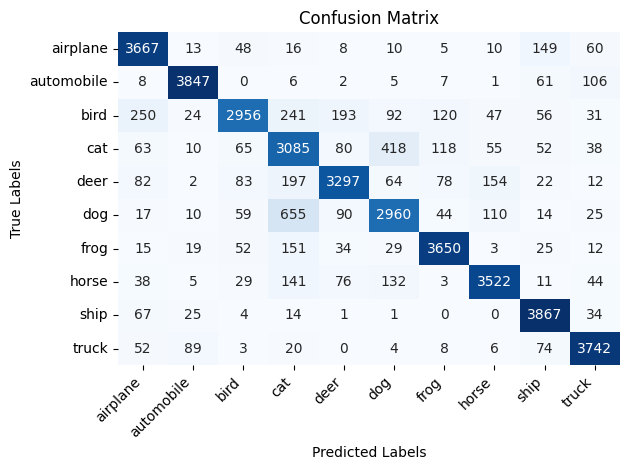

In [22]:
confusion(train_loader, net3)

After looking at the confusion matrix, we can clearly observe how the model performs much better. Nonetheless, we can still identify the same mismatches going on between animals like dogs and cats, but in a much lower level. In addition, we can see that the label that the model struggles the most to classify is the bird label, with 2956 accurate predictions.

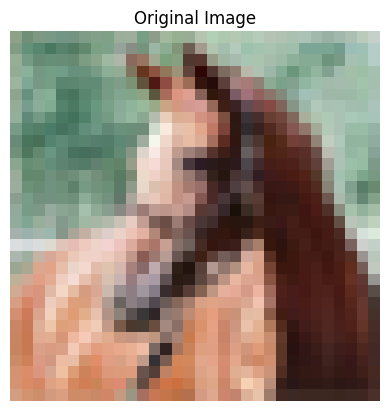

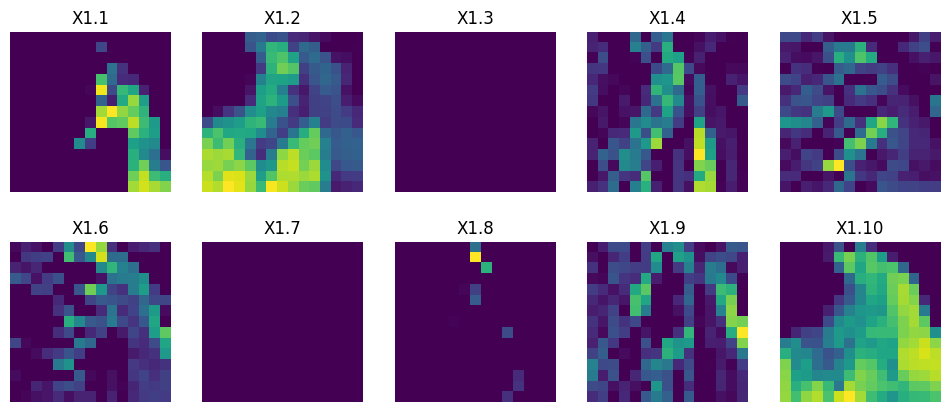

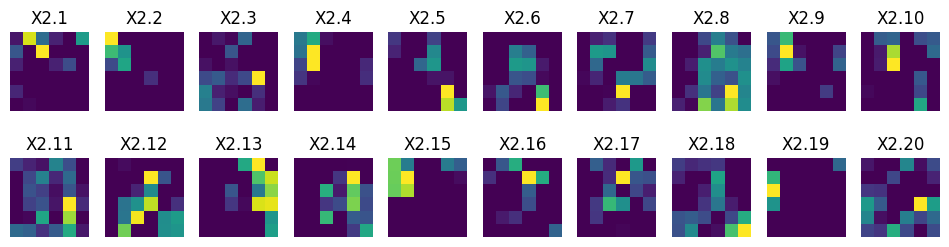

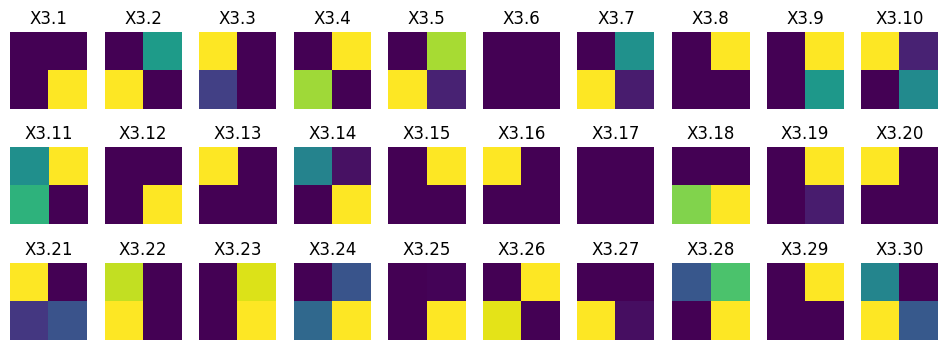

In [29]:
visualize_intermediate_features(train_loader, net3)

This graph shows us the intermediate features for the 3 convolution layers. As one can observe, the first layers start identifying textures and edges, and as we go deeper into the network, we can start observing more complex shapes, like the siloutte of the horse.

In [24]:
test(net3)

Testing Loss: 1.1094991602715414
Testing Accuracy: 0.6746999621391296


The model performed fairly well for the testing set, with an accuracy of 67.5%.

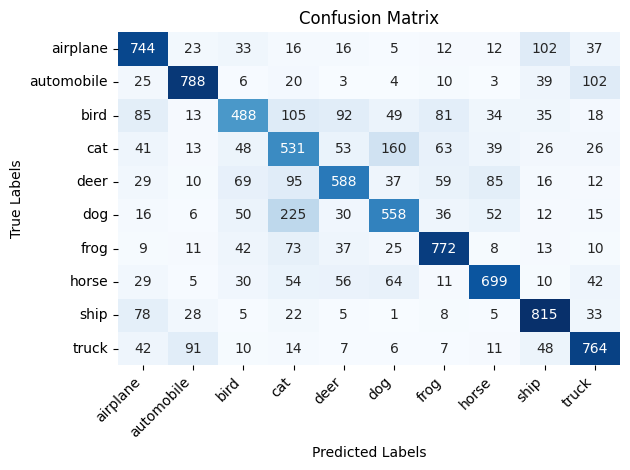

In [25]:
confusion(test_loader, net3)

The confusion matrix shows the same pattern as before, the bird label being the weakest one and a lot of mismatched between dogs and cats.

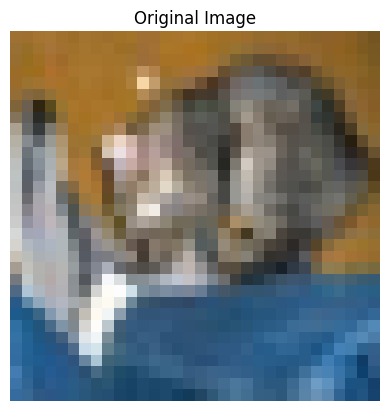

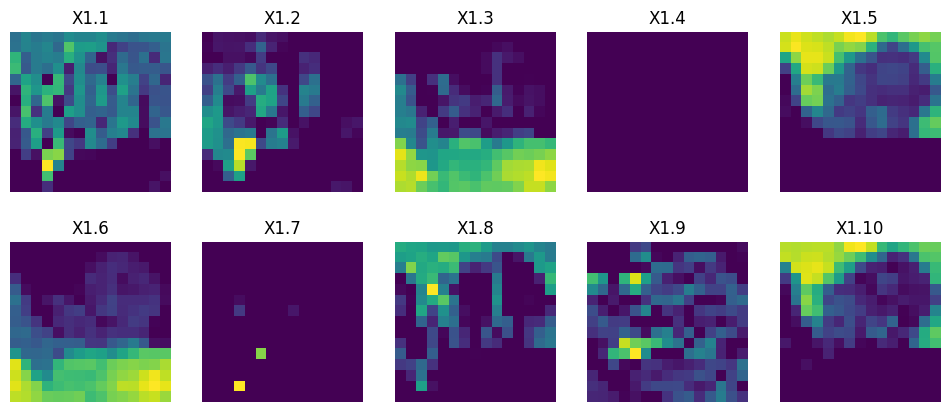

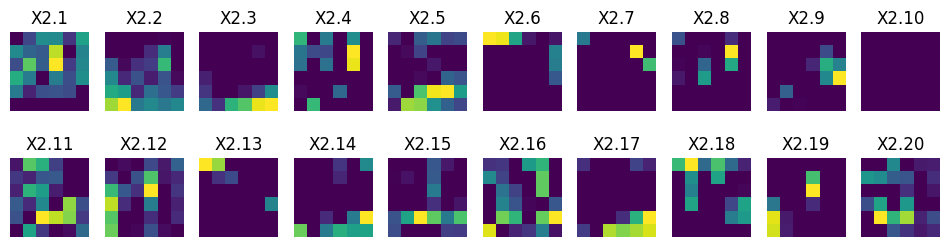

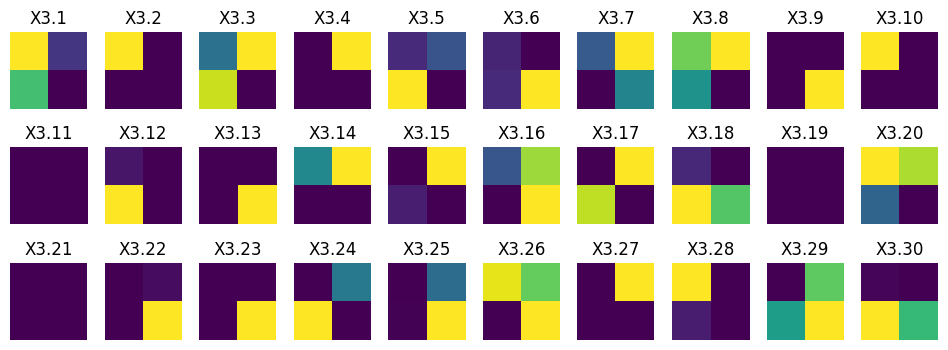

In [26]:
visualize_intermediate_features(test_loader, net2)

Data augmentation is a technique commonly used in machine learning and computer vision to artificially expand a given dataset by applying various transformations to the existing data. It involves creating new training examples by making modifications to the original data, while preserving the label or class information.

The main goal of data augmentation is to increase the diversity and variability of the training data, which helps to improve the generalization and robustness of machine learning models. By exposing the model to a wider range of variations and patterns, it can learn more effectively and perform better on unseen or real-world data.

As we saw before, the model started overfitting when training for a higher number of epochs. Let's apply some transformations to the data to check if we can solve this problem.

In [69]:
def cifar10_augmented(batch_sz, valid_size=0.2, shuffle=True, random_seed=2000):
  transform_train = transforms.Compose([
      transforms.RandomRotation(5),
      transforms.RandomHorizontalFlip(0.1),
      transforms.ColorJitter(0.1,0.1,0.1,0.1),
      transforms.ToTensor(),
  ])
  transform_valid = transforms.ToTensor()
  transform_test = transforms.ToTensor()

  train_dataset = CIFAR10(root='./datasets', train=True, download=True, transform=transform_train)
  valid_dataset = CIFAR10(root='./datasets', train=True, download=True, transform=transform_valid)

  num_train = len(train_dataset)
  indices = list(range(num_train))
  split = int(np.floor(valid_size * num_train))
  if shuffle:
    np.random.seed(random_seed)
    np.random.shuffle(indices)
  train_idx, valid_idx = indices[split:], indices[:split]

  train_sampler = SubsetRandomSampler(train_idx)
  valid_sampler = SubsetRandomSampler(valid_idx)
  train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_sz, sampler=train_sampler, pin_memory=True)
  valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_sz, sampler=valid_sampler, pin_memory=True)

  test_dataset = CIFAR10(root='./datasets', train=False, download=True, transform=transform_test)
  test_loader = DataLoader(test_dataset, batch_size=batch_sz)

  return train_loader, valid_loader, test_loader


It is important to say that we only apply the transformnations to the training set, as we want to leave the validation and testing sets as accurate to the actual information as possible.

In [31]:
batch_sz=64 # this is batch size i.e. the number of rows in a batch of data

train_loader, valid_loader, test_loader = cifar10_augmented(batch_sz)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


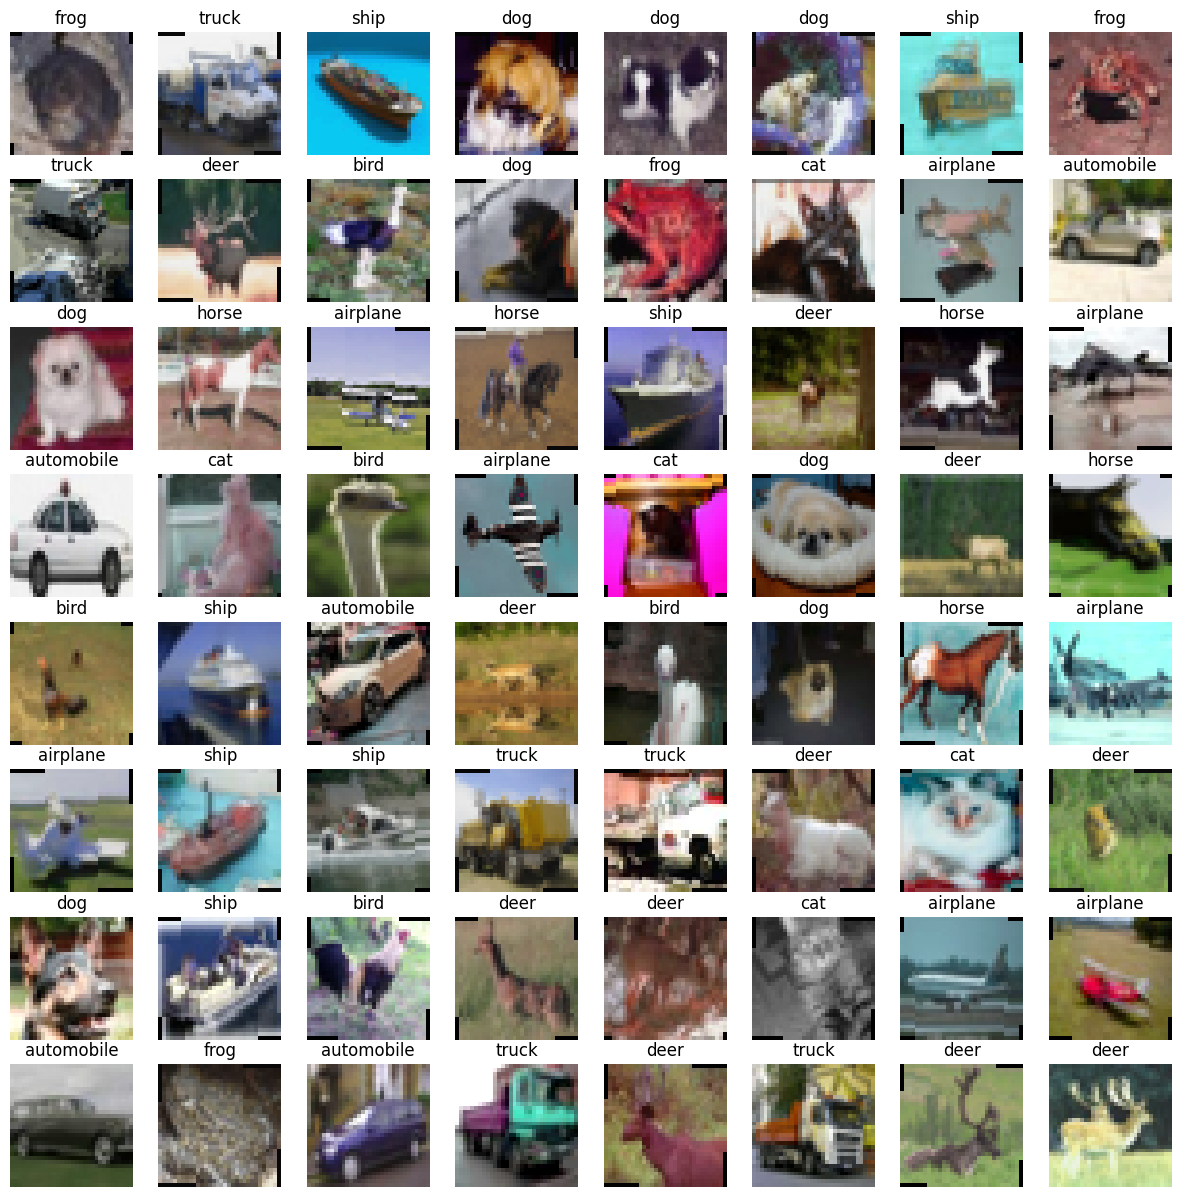

In [32]:
batch = next(iter(train_loader))
images = batch[0]
labels = batch[1]
plt.figure(figsize=(15,15))
for i in range(64):
  plt.subplot(8,8,i+1)
  img = np.transpose(images[i].numpy(), (1, 2, 0))  # Transpose the image dimensions
  plt.imshow(img)
  plt.title(label_str(labels[i].item()))
  plt.axis("off")

Here we can observe the random rotations, color jitters, and horizontal flips.

In [33]:
in_ch = 3
out_ch1 = 20
out_ch2 = 40
out_ch3 = 60
k_sz = 3
nh1 = 60
nh2 = 120
nh3 = 240
no = 10
stride = 1

net4 = MyCNN(in_ch, out_ch1, out_ch2, out_ch3, k_sz, nh1, nh2, nh3, no, stride)

Time to train the model with the brand new data loaders.

Adjusting learning rate of group 0 to 2.0000e-02.
Adjusting learning rate of group 0 to 1.8000e-02.
Epoch 0: Training Loss: 2.273484895053582, Validation Loss: 2.0974614841815753
Epoch 0: Training Accuracy: 0.121, Validation Accuracy: 0.2091
Adjusting learning rate of group 0 to 1.6200e-02.
Adjusting learning rate of group 0 to 1.4580e-02.
Epoch 2: Training Loss: 1.540371482570966, Validation Loss: 1.363824153557802
Epoch 2: Training Accuracy: 0.4349, Validation Accuracy: 0.5048
Adjusting learning rate of group 0 to 1.3122e-02.
Adjusting learning rate of group 0 to 1.1810e-02.
Epoch 4: Training Loss: 1.2176633355900264, Validation Loss: 1.1705286029057624
Epoch 4: Training Accuracy: 0.564775, Validation Accuracy: 0.5845
Adjusting learning rate of group 0 to 1.0629e-02.
Adjusting learning rate of group 0 to 9.5659e-03.
Epoch 6: Training Loss: 1.0508416507106562, Validation Loss: 1.0880052485527136
Epoch 6: Training Accuracy: 0.6312, Validation Accuracy: 0.6227
Adjusting learning rate of

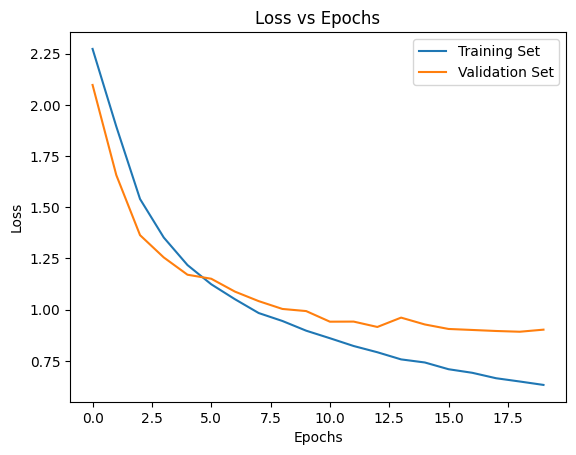

In [34]:
conv20aug_tr, conv20aug_val = train(net4, 20, 2e-2, 0.9)

Already we can see an improvement on the validation accuracy, with a final magnitude of 69.7%

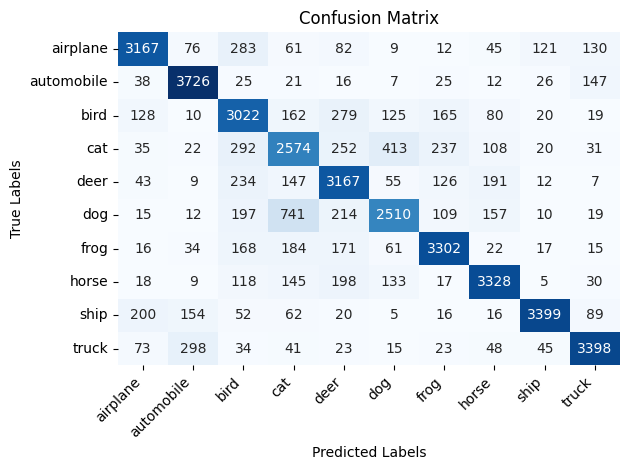

In [35]:
confusion(train_loader, net4)

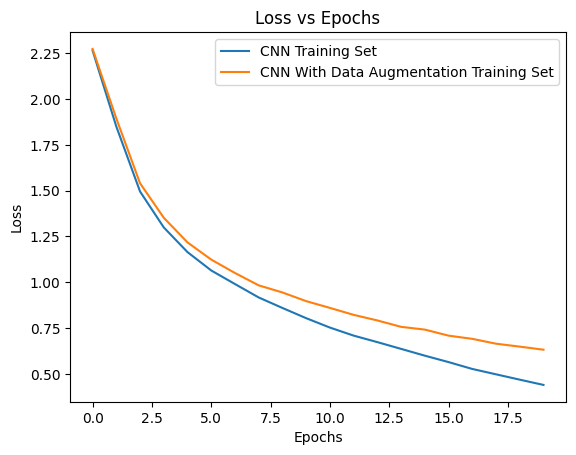

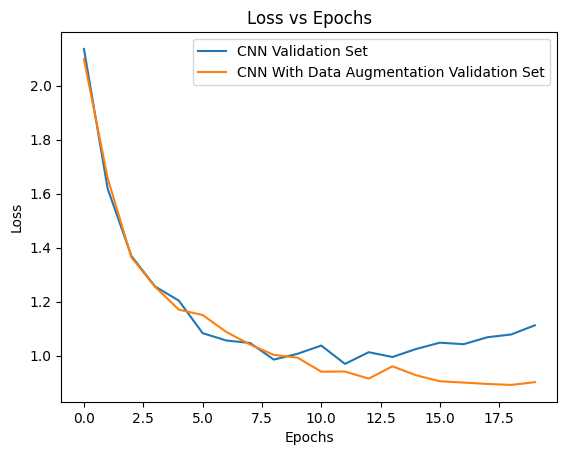

In [36]:
plt.figure()
# Plot the data
plt.plot(conv20_tr, label='CNN Training Set')
plt.plot(conv20aug_tr, label='CNN With Data Augmentation Training Set')

# Add legend
plt.legend()

# Add title and labels
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Display the graph
plt.show()

plt.figure()
# Plot the data
plt.plot(conv20_val, label='CNN Validation Set')
plt.plot(conv20aug_val, label='CNN With Data Augmentation Validation Set')

# Add legend
plt.legend()

# Add title and labels
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Display the graph
plt.show()

By plotting the training and validation loss function of both the model with augmentation and without, we can observe some interesting behaviour. On one hand, we can see that the model without augmentation learns faster on the training set, achieving better results. However, we can see that the validation loss function is now performing better with augmentation, solving the overfitting problem we were observing on a significant scale.

In [37]:
test(net4)

Testing Loss: 0.8757611672589733
Testing Accuracy: 0.7076999545097351


The testing accuracy also improved, with 70.8%!

In [38]:
test(net3)

Testing Loss: 1.1094991602715414
Testing Accuracy: 0.6746999621391296


While the previous one was 67.5%

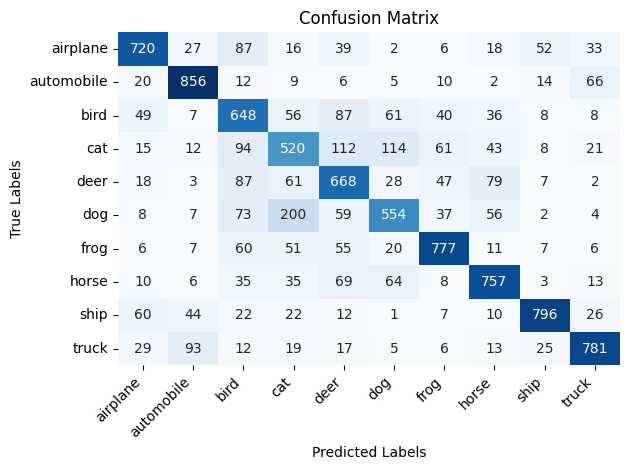

In [39]:
confusion(test_loader, net4)

Transfer learning means taking the relevant parts of a pre-trained machine learning model and applying it to a new but similar problem. Transfer learning brings a range of benefits to the development process of machine learning models. The main benefits of transfer learning include the saving of resources and improved efficiency when training new models. It can also help with training models when only unlabelled datasets are available, as the bulk of the model will be pre-trained.

![Transfer Learning](https://topb0ts.wpenginepowered.com/wp-content/uploads/2019/12/cover_transfer_learning_1600px_web.jpg) [Source](https://www.topbots.com/transfer-learning-in-nlp/)

Is 70% the best we can do with machine learning? Certainly not, however, pretrained models on much bigger datasets can help us tackle problems like this, where datasets of fewer samples don't provide enough knowledge to our models.

In [42]:
net5 = models.resnet18(pretrained=True)
net5.fc = nn.Linear(in_features=512, out_features=10, bias=True)

We will be using the resnet18 network pretrained for the ImageNet dataset. This dataset consists of millions of labeled images from a wide range of categories, such as animals, objects, and scenes. The only fintuning going on here lays on the final layer, as we need to specify that there are only 10 labels for our dataset.

Adjusting learning rate of group 0 to 2.0000e-02.
Adjusting learning rate of group 0 to 1.8000e-02.
Epoch 0: Training Loss: 1.6841978119351926, Validation Loss: 1.63742741331076
Epoch 0: Training Accuracy: 0.4486, Validation Accuracy: 0.5032
Adjusting learning rate of group 0 to 1.6200e-02.
Adjusting learning rate of group 0 to 1.4580e-02.
Epoch 2: Training Loss: 0.9082995089582908, Validation Loss: 0.8270538441645794
Epoch 2: Training Accuracy: 0.689, Validation Accuracy: 0.7129
Adjusting learning rate of group 0 to 1.3122e-02.
Adjusting learning rate of group 0 to 1.1810e-02.
Epoch 4: Training Loss: 0.6199257324616878, Validation Loss: 0.7062002846445793
Epoch 4: Training Accuracy: 0.784125, Validation Accuracy: 0.7602
Adjusting learning rate of group 0 to 1.0629e-02.
Adjusting learning rate of group 0 to 9.5659e-03.
Epoch 6: Training Loss: 0.49535974513930386, Validation Loss: 0.6605424382365667
Epoch 6: Training Accuracy: 0.830675, Validation Accuracy: 0.7775
Adjusting learning rat

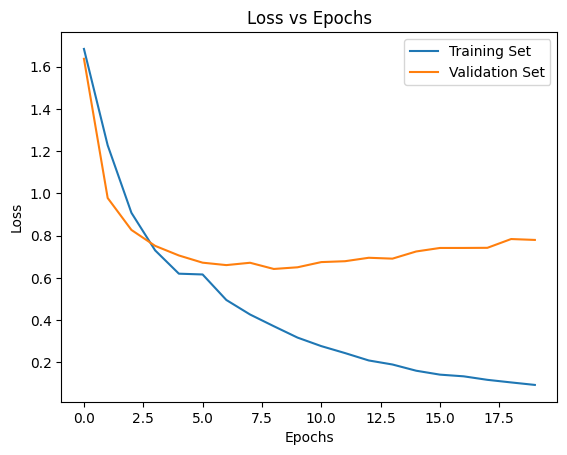

In [43]:
resnet_tr, resnet_val = train(net5, 20, 2e-2, 0.9)

Already we can observe much effective results, with an increase in accuracy of around 10%!

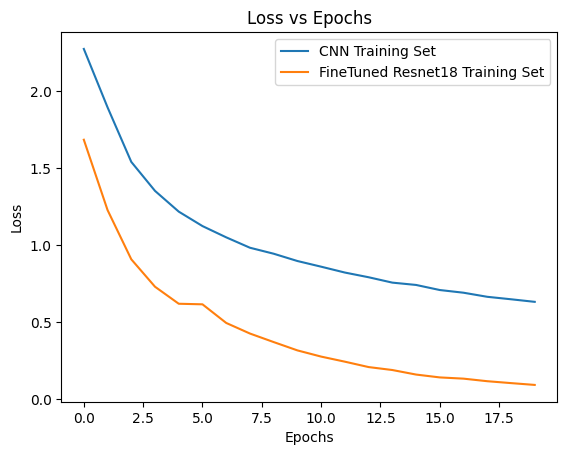

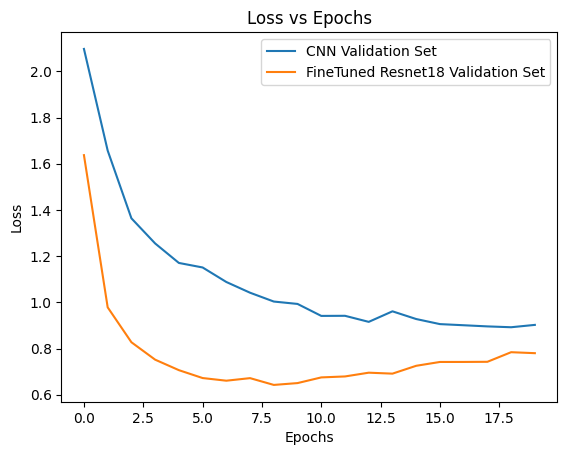

In [57]:
plt.figure()
# Plot the data
plt.plot(conv20aug_tr, label='CNN Training Set')
plt.plot(resnet_tr, label='FineTuned Resnet18 Training Set')

# Add legend
plt.legend()

# Add title and labels
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Display the graph
plt.show()

plt.figure()
# Plot the data
plt.plot(conv20aug_val, label='CNN Validation Set')
plt.plot(resnet_val, label='FineTuned Resnet18 Validation Set')

# Add legend
plt.legend()

# Add title and labels
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Display the graph
plt.show()

By comparing the resnet18 model with our previous CNN we can see that the starting loss is much smaller for the pretrained network for both the validation and training sets. However, we can also identify some slight overfitting on the training set going on with the resnet18 network, which starts appearing at around 8 epochs.

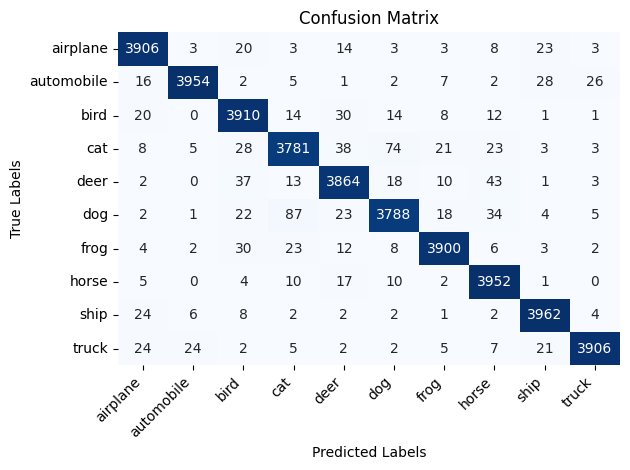

In [44]:
confusion(train_loader, net5)

Now this confusion matrix looks much more balanced. We can see that we solved the problem with the bird label being the weakest and there is not a significant mismatch between dogs and cats anymore.

In [45]:
test(net5)

Testing Loss: 0.7395002558163017
Testing Accuracy: 0.8202999830245972


A testing accuracy of 82.0%!

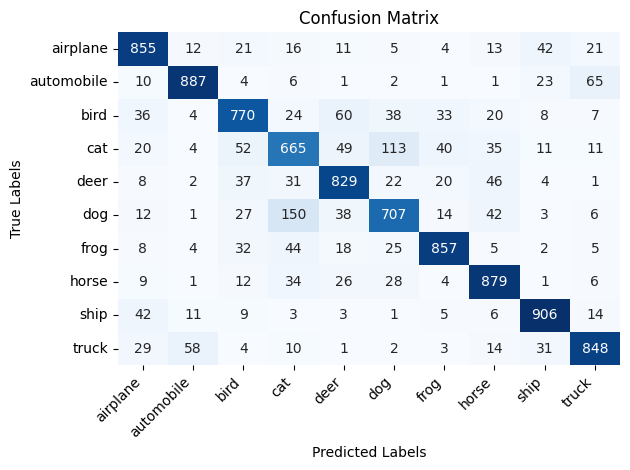

In [46]:
confusion(test_loader, net5)

However, the testing is still clearly struggling with the labels mentioned before, specifically the dog and cat mismatch problem.

Now, is this the best we can do? In many implementations, including the one in PyTorch, the default input size for the ResNet models is 224x224 pixels. But we are feeding it 32x32 pixel images. Let's fix this by resizing the images to 224x224 pixels.

In [55]:
from PIL import Image

def resize_cifar10_images(image):
    # Resize the image to 224x224
    resized_image = image.resize((224, 224), Image.BILINEAR)

    return resized_image

In [59]:
def cifar10_finetuned(batch_sz, valid_size=0.2, shuffle=True, random_seed=2000):
  transform_train = transforms.Compose([
      transforms.RandomRotation(5),
      transforms.RandomHorizontalFlip(0.1),
      transforms.ColorJitter(0.1,0.1,0.1,0.1),
      transforms.Lambda(lambda x: resize_cifar10_images(x)),
      transforms.ToTensor()
  ])
  transform_valid = transforms.Compose([transforms.Lambda(lambda x: resize_cifar10_images(x)),
                                        transforms.ToTensor()
  ])
  transform_test = transforms.Compose([transforms.Lambda(lambda x: resize_cifar10_images(x)),
                                       transforms.ToTensor()
  ])

  train_dataset = CIFAR10(root='./datasets', train=True, download=True, transform=transform_train)
  valid_dataset = CIFAR10(root='./datasets', train=True, download=True, transform=transform_valid)

  num_train = len(train_dataset)
  indices = list(range(num_train))
  split = int(np.floor(valid_size * num_train))
  if shuffle:
    np.random.seed(random_seed)
    np.random.shuffle(indices)
  train_idx, valid_idx = indices[split:], indices[:split]

  train_sampler = SubsetRandomSampler(train_idx)
  valid_sampler = SubsetRandomSampler(valid_idx)
  train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_sz, sampler=train_sampler, pin_memory=True)
  valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_sz, sampler=valid_sampler, pin_memory=True)

  test_dataset = CIFAR10(root='./datasets', train=False, download=True, transform=transform_test)
  test_loader = DataLoader(test_dataset, batch_size=batch_sz)

  return train_loader, valid_loader, test_loader


When it comes to applying transformations, including resizing, to the CIFAR-10 dataset, it is generally recommended to apply them only to the training set and not to the testing set.

By resizing the validation and testing images to the same size as the training set, you ensure that all sets have consistent dimensions, which allows the model to evaluate the data appropriately. This helps maintain fairness and consistency throughout the evaluation process.

Applying the same transformations to all sets also helps to uncover any issues or challenges that may arise when processing images of different sizes, and it provides a more accurate assessment of the model's generalization and performance.

In [60]:
batch_sz=64 # this is batch size i.e. the number of rows in a batch of data

train_loader, valid_loader, test_loader = cifar10_finetuned(batch_sz)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


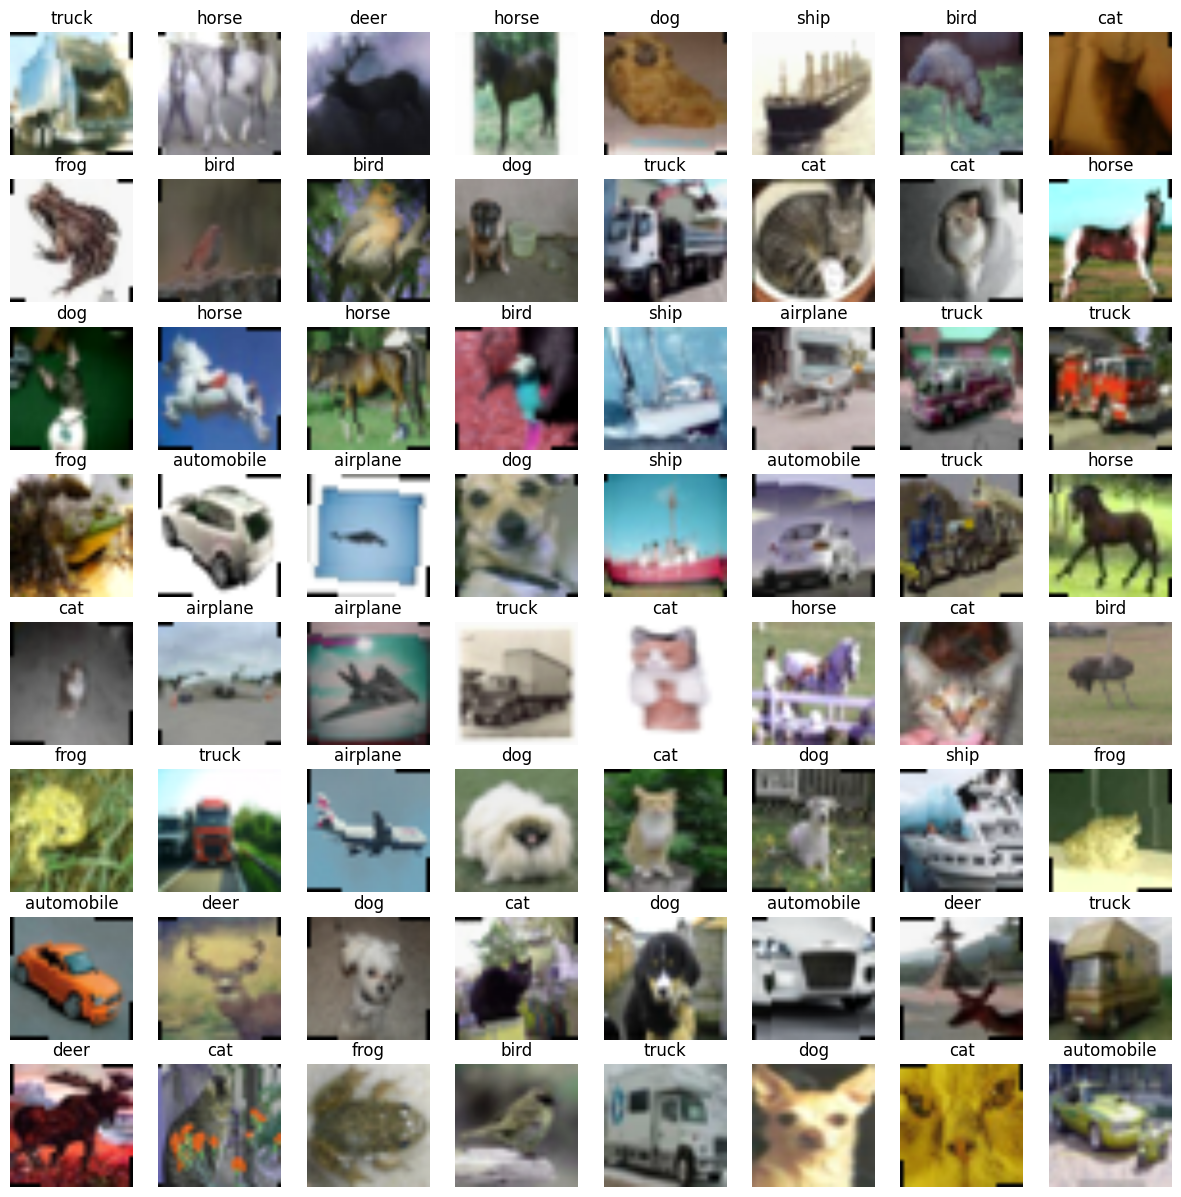

In [61]:
batch = next(iter(train_loader))
images = batch[0]
labels = batch[1]
plt.figure(figsize=(15,15))
for i in range(64):
  plt.subplot(8,8,i+1)
  img = np.transpose(images[i].numpy(), (1, 2, 0))  # Transpose the image dimensions
  plt.imshow(img)
  plt.title(label_str(labels[i].item()))
  plt.axis("off")

These are now the brand new 224x224 images

In [62]:
net6 = models.resnet18(pretrained=True)
net6.fc = nn.Linear(in_features=512, out_features=10, bias=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Adjusting learning rate of group 0 to 2.0000e-02.
Adjusting learning rate of group 0 to 1.8000e-02.
Epoch 0: Training Loss: 0.669749410273746, Validation Loss: 0.37996220206603026
Epoch 0: Training Accuracy: 0.78195, Validation Accuracy: 0.8754
Adjusting learning rate of group 0 to 1.6200e-02.
Adjusting learning rate of group 0 to 1.4580e-02.
Epoch 2: Training Loss: 0.2002580872951792, Validation Loss: 0.2548548840941527
Epoch 2: Training Accuracy: 0.930625, Validation Accuracy: 0.9142
Adjusting learning rate of group 0 to 1.3122e-02.
Adjusting learning rate of group 0 to 1.1810e-02.
Epoch 4: Training Loss: 0.09335498520597003, Validation Loss: 0.2615466960049115
Epoch 4: Training Accuracy: 0.968425, Validation Accuracy: 0.9226
Adjusting learning rate of group 0 to 1.0629e-02.
Adjusting learning rate of group 0 to 9.5659e-03.
Epoch 6: Training Loss: 0.04970527971267867, Validation Loss: 0.2464036094263578
Epoch 6: Training Accuracy: 0.98345, Validation Accuracy: 0.9323
Adjusting learni

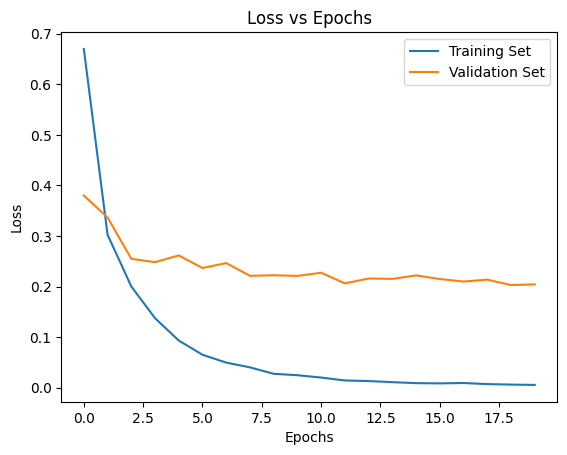

In [63]:
resnetImageTuned_tr, resnetImageTuned_val = train(net6, 20, 2e-2, 0.9)

Wow! A final validation accuracy of 95%! The accuracy for the training set is also almost perfect (99.8%). This approach also solved the overfitting problem previousy observed.

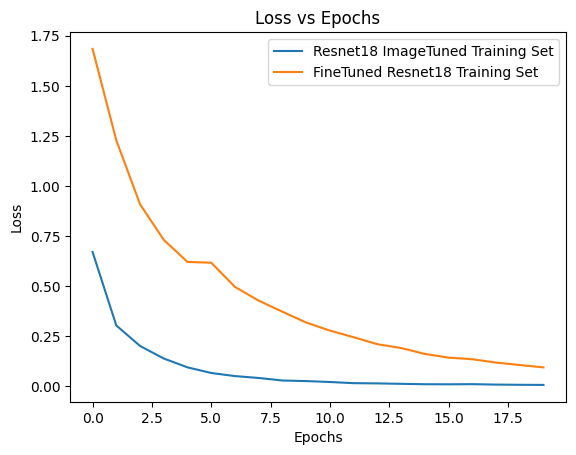

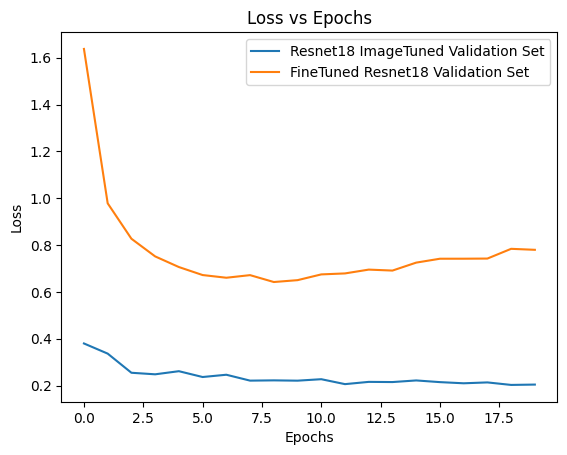

In [64]:
plt.figure()
# Plot the data
plt.plot(resnetImageTuned_tr, label='Resnet18 ImageTuned Training Set')
plt.plot(resnet_tr, label='FineTuned Resnet18 Training Set')

# Add legend
plt.legend()

# Add title and labels
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Display the graph
plt.show()

plt.figure()
# Plot the data
plt.plot(resnetImageTuned_val, label='Resnet18 ImageTuned Validation Set')
plt.plot(resnet_val, label='FineTuned Resnet18 Validation Set')

# Add legend
plt.legend()

# Add title and labels
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Display the graph
plt.show()

These plots help us the visualize clear improvements. Now it's clear that it wasn't fair for us the feed the model differently sized images to the ones that were used to train it in the first place. Particularly, it is really impressive how low the loss start for the validation set, and how it stays almost constant throught the 20 epochs.

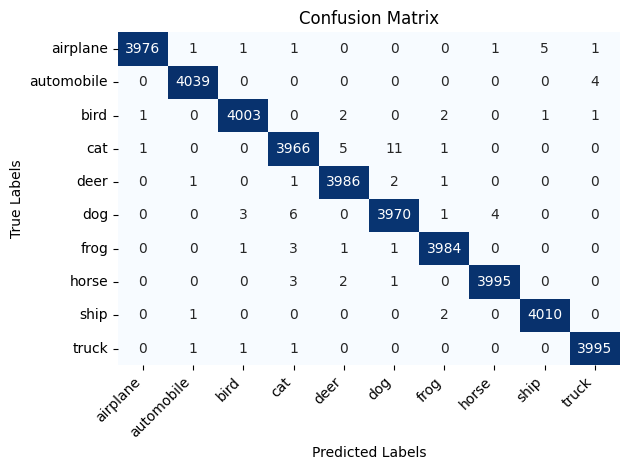

In [65]:
confusion(train_loader, net6)

This matrix shows us almost perfect results, with very few mismatches between labels.

In [66]:
test(net6)

Testing Loss: 0.18219238568014304
Testing Accuracy: 0.9521999955177307


The testing accuracy is also of 95%!

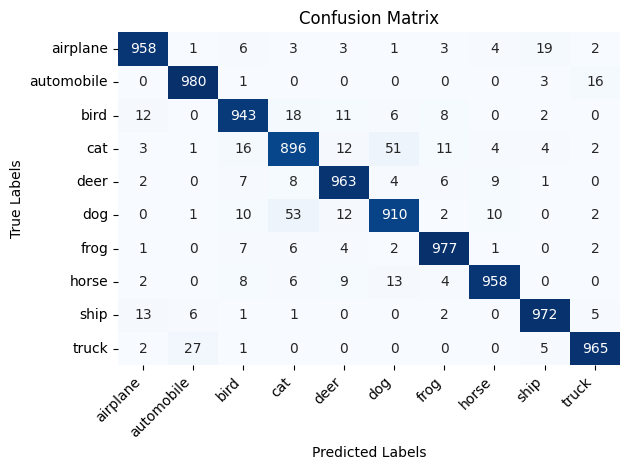

In [67]:
confusion(test_loader, net6)

To finish, the confusion matrix for the testing set in this implementation is looking much better. However, it's interesting to see how even the most prestigious models struggle a little with dogs and cats.